# ME 793 - Multiscale Materials Informatics, Discovery and Design
# Instructor : A. Alankar

# Tutorial 11 - NN Regression and Various Optimisers

### For a given learning rate, epochs and other default setup, run the model for RMSProp, Adam and Gradient Descent and compare the loss vs. epochs

**Outline:**

1. Getting data
2. Processing and Organizing Data
3. Creating the Model
4. Plotting
## Assignment 05

### 0. Import libraries

In [2]:
import tensorflow as tf
# You may not be able to install tensorflow using conda install inside pytmatgen.
# use pip install tensorflow

from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import mean_absolute_error

import pymatgen.core as pymat
import mendeleev as mendel
import pandas as pd
import numpy as np

import sys
import os
sys.path.insert(0, '../src/')

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
!pip install pymatgen

In [ ]:
!pip install mendeleev

### 1. Getting a dataset

In [3]:
fcc_elements = ["Ag", "Al", "Au", "Cu", "Ir", "Ni", "Pb", "Pd", "Pt", "Rh", "Th", "Yb"]
bcc_elements = ["Ba", "Cr", "Eu", "Fe", "Li", "Mn", "Mo", "Na", "Nb", "Ta", "V", "W" ]
hcp_elements = ["Be", "Ca", "Cd", "Co", "Dy", "Er", "Gd", "Hf", "Ho", "Lu", "Mg", "Re", 
                "Sc", "Tb", "Ti", "Tl", "Tm", "Y", "Zn"]

elements = fcc_elements + bcc_elements + hcp_elements

querable_mendeleev = ["atomic_number", "atomic_volume", "boiling_point",
                      "en_ghosh",  "evaporation_heat", "heat_of_formation",
                     "lattice_constant", "specific_heat"]

# en_ghosh is Ghosh's scale of electronegativity. See this: https://doi.org/10.1142/S0219633605001556
# There are many such scale.

querable_pymatgen = ["atomic_mass", "atomic_radius", "electrical_resistivity",
                     "molar_volume", "bulk_modulus", "youngs_modulus",
                     "average_ionic_radius", "density_of_solid",
                     "coefficient_of_linear_thermal_expansion"]

querable_values = querable_mendeleev + querable_pymatgen

# Note that in this examples, two different APIs are used and two different sets of features have been collected.
# These features have been collated in a single set of queable values.
#np.shape(elements)

##### Querying the database

In [4]:
all_values = [] # Values for Attributes
all_labels = [] # Values for Young's Modulus (Property to be estimated)

# This neural network will produce a virtual function that will give Young's modulus E
#E = E(values)
#E = E(atomic number, atomic mass, boiling point......)

for item in elements:
    element_values = []
    
    # This section queries Mendeleev
    element_object = mendel.element(item)
    for i in querable_mendeleev:    
        element_values.append(getattr(element_object,i))

    # This section queries Pymatgen
    element_object = pymat.Element(item)    
    for i in querable_pymatgen:
        element_values.append(getattr(element_object,i))
        
    all_values.append(element_values) # All lists are appended to another list, creating a list of lists
    
# Pandas Dataframe
df = pd.DataFrame(all_values, columns=querable_values)


# The labels (values for Young's modulus) are stored separately for clarity (We drop the column later)

df.to_csv(os.path.expanduser('element_data.csv'), index=False, compression=None) # this line saves the data we collected into a .csv file into your home directory

all_labels = df['youngs_modulus'].tolist()

df = df.drop(['youngs_modulus'], axis=1)

#df.head(n=10) # With this line you can see the first ten entries of our database
df

,atomic_number,atomic_volume,boiling_point,en_ghosh,evaporation_heat,heat_of_formation,lattice_constant,specific_heat,atomic_mass,atomic_radius,electrical_resistivity,molar_volume,bulk_modulus,average_ionic_radius,density_of_solid,coefficient_of_linear_thermal_expansion
0,47,10.30,2435.15,0.147217,254.1,284.90,4.09,0.235,107.868200,1.60,1.630000e-08,10.27,100.0,1.086667,10490.0,0.000019
1,13,10.00,2792.15,0.150078,284.1,330.90,4.05,0.897,26.981539,1.25,2.700000e-08,10.00,76.0,0.675000,2700.0,0.000023
2,79,10.20,3109.15,0.261370,340.0,368.20,4.08,0.129,196.966569,1.35,2.200000e-08,10.21,220.0,1.070000,19300.0,0.000014
3,29,7.10,2833.15,0.151172,304.6,337.40,3.61,0.385,63.546000,1.35,1.720000e-08,7.11,140.0,0.820000,8920.0,0.000017
4,77,8.54,4701.15,0.251060,604.0,669.00,3.84,0.131,192.217000,1.35,4.700000e-08,8.52,320.0,0.765000,22650.0,0.000006
5,28,6.60,3186.15,0.147207,378.6,430.10,3.52,0.444,58.693400,1.35,7.200000e-08,6.59,180.0,0.740000,8908.0,0.000013
6,82,18.30,2022.15,0.177911,177.8,195.20,4.95,0.130,207.200000,1.80,2.100000e-07,18.26,46.0,1.122500,11340.0,0.000029
7,46,8.90,3236.15,0.144028,372.4,376.60,3.89,0.246,106.420000,1.40,1.080000e-07,8.56,180.0,0.846250,12023.0,0.000012
8,78,9.10,4098.15,0.256910,470.0,565.70,3.92,0.133,195.084000,1.35,1.060000e-07,9.09,230.0,0.805000,21090.0,0.000009
9,45,8.30,3968.15,0.140838,494.0,556.00,3.80,0.243,102.905500,1.35,4.300000e-08,8.28,380.0,0.745000,12450.0,0.000008


### 2. Processing and Organizing Data

Most machine learning models are trained on a subset of all the available data, called the "training set", and the models are tested on the remainder of the available data, called the "testing set". Model performance has often been found to be enhanced when the inputs are normalized.

##### SETS

With the dataset we just created, we have 44 entries for our model. We will train with 39 cases and test on the remaining 5 elements to estimate Young's Modulus.

##### NORMALIZATION

Each one of these input data features has different units and is represented in scales with distinct orders of magnitude. Datasets that contain inputs like this need to be normalized, so that quantities with large values do not bias the neural network, forcing it tune its weights to account for the different scales of our input data. In this tutorial, we will use the Standard Score Normalization, which subtracts the mean of the feature and divide by its standard deviation.

<span style="font-size:2em;">$ \frac{X - µ}{σ} $ </span>

While our model might converge without feature normalization, the resultant model would be difficult to train and would be dependent on the choice of units used in the input.

In [4]:
 df.to_excel('tut_11_data.xlsx', index=False)

In [5]:
#We will rewrite the arrays with the patches we made on the dataset by turning the dataframe back into a list of lists

all_values = [list(df.iloc[x]) for x in range(len(all_values))]
# all_values is a list of lists.

# read about df.iloc here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html

# SETS

# List of lists are turned into Numpy arrays to facilitate calculations in steps to follow (Normalization).
all_values = np.array(all_values, dtype = float) 
print("Shape of Values:", all_values.shape)
all_labels = np.array(all_labels, dtype = float)
print("Shape of Labels:", all_labels.shape)

# Uncomment the line below to shuffle the dataset (we do not do this here to ensure consistent results for every run)
#order = np.argsort(np.random.random(all_labels.shape)) # This numpy argsort returns the indexes that would be used to shuffle a list
order = np.arange(43)
all_values = all_values[order]
all_labels = all_labels[order]

# Training Set, this is a manual partition. If we do the above shuffling, there will be different training set
# for each training set.
# We have 43 elements in our dataframe i.e. numpy dataset now. Our of those, 38 are used for training.
# Training data includes actual training or 'fitting' and validation. This validation is done on-the-fly using
# some of the data from training data set. It is called validation dataset. In this examples we have 10 % data
# used for validation.
# So, training data. = actual training data + validation data

train_labels = all_labels[:38]
train_values = all_values[:38]

# Testing Set. This dataset is not seen at all by the model before it is fitted.
test_labels = all_labels[-5:]
test_values = all_values[-5:]

# This line is used for labels in the plots at the end of the tutorial - Testing Set
labeled_elements = [elements[x] for x in order[-5:]] 
elements = [elements[x] for x in order]

# NORMALIZATION

mean = np.mean(train_values, axis = 0) # mean, calculating mean for each row.
std = np.std(train_values, axis = 0) # standard deviation

train_values = (train_values - mean) / std # input scaling
test_values = (test_values - mean) / std # input scaling

mean_all = np.mean(all_values, axis = 0) # mean, calculating mean for each row.
std_all = np.std(all_values, axis = 0) # standard deviation
all_values_normalized = (all_values - mean_all) / std_all # input scaling

print(train_values[0]) # print a sample entry from the training set
print(test_values[0]) # print a sample entry from the testing set
print(order)

Shape of Values: (43, 16)
Shape of Labels: (43,)
[-0.04080514 -0.50673999 -0.61573665 -0.48000707 -0.59640276 -0.57914974
  0.23007252 -0.34851127 -0.1169633   0.27242314 -0.74442966 -0.50761875
 -0.23457382  0.8715687   0.20497176  0.23990096]
[-1.03477644 -0.46692446  0.25397834 -0.97359468  0.30431353  0.3650567
 -0.78177941  0.11430967 -1.03412225 -0.62775766  0.23766706 -0.45697574
 -0.13693109 -0.39396025 -0.84271597 -0.55854493]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


### 3. Defining the Model, Training, Testing and Predictions

## .Q1  For learning rate 0.001, epochs 20000 and other default setup, run the model for RMSProp, Adam and Gradient Descent and compare the accuracy vs. epochs. Write your observation and reasoning.

#### RMSProp Optimiser

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


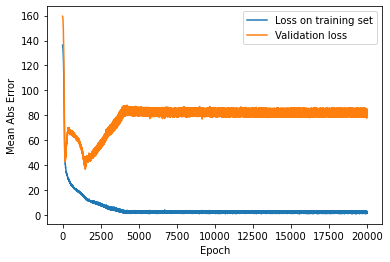

In [6]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0) # initialization of seed will always produce same result.
bias_init = initializers.Zeros()

model = Sequential() # one input layer and one output layer
# https://keras.io/guides/sequential_model/

model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS

# CHOOSING THE OPTIMIZER

optimizer = optimizers.RMSprop(learning_rate=my_learning_rate,decay=my_decay_rate) # RMSProp. Initial learning rate has been set to 0.001
# optimizer = optimizers.Adam(0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD
#
# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
# mae is Mean Absolute Error
# Read more about regression losses: https://keras.io/api/losses/regression_losses/

model.summary() # this will show a chart of the 'architecture' of the model i.e. arrangement of layers etc.

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])

# Validation split is the 10 % of training data which will be used for on-the-fly 'verification' of fit.

# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

####  RMSProp is an optimization algorithm that adapts the learning rate for each parameter based on the average of the squared gradients for that parameter. It can improve the convergence of the model by decreasing the learning rate for parameters with high variance
##### However after certain  number of epochs the validation loss shoots up again due to overfitting of the data and not actually capturing the pattern of the data. We can also see that loss on training dataset continuously decreases due to minimisation of biasness of the data but the variance shoots up as both are inversely proportion 

2/2 [==============================] - 0s 5ms/step


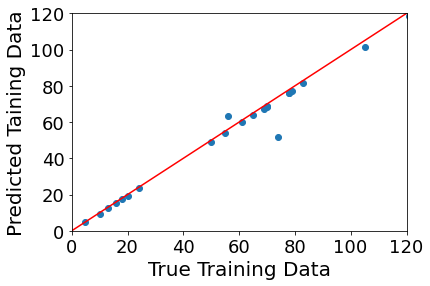

In [7]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
#
plt.scatter(train_labels,train_labels_predict)
plt.ylabel('Predicted Taining Data',fontsize=20)
plt.xlabel('True Training Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

1/1 [==============================] - 0s 80ms/step


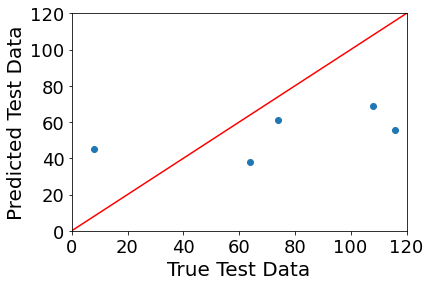

In [8]:
# Check the predictions of only test data by the model
test_labels_predict=model.predict(test_values)
#np.shape(test_labels_predict)
#np.shape(test_labels)
# Plot the predictions of only test data by the model
plt.scatter(test_labels,test_labels_predict)
plt.ylabel('Predicted Test Data',fontsize=20)
plt.xlabel('True Test Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

#### Adam Optimiser

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                272       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 128)               4224      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


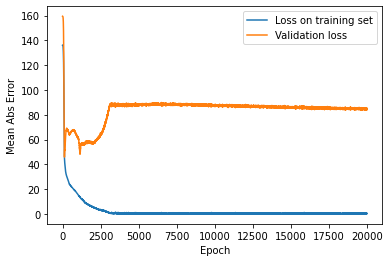

In [10]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

 The Adam optimizer is a popular optimization algorithm used for training neural networks. It is an adaptive learning rate optimization algorithm that combines the advantages of two other optimization techniques: AdaGrad and RMSProp. During the training process, the Adam optimizer updates the model's weights by taking into account the gradients of the loss function with respect to the weights. The optimizer uses a combination of the first and second moments of the gradients to update the weights. of the first and second moments of the gradients to update the weights.. 
 
 
 In some cases, after a certain number of epochs, the validation loss may increase while the training loss continues to decrease. This phenomenon is called overfitting. Overfitting occurs when the model becomes too complex and starts to fit the training data too closely, resulting in poor performance on new data (i.e., the validation set). One possible explanation for this behavior is that the model has learned to fit the noise in the training data instead of the underlying patterns. As a result, the model becomes less generalizable to new data, which leads to an increase in the validation loss

### Predictions by ADAM optimizer

2/2 [==============================] - 0s 4ms/step


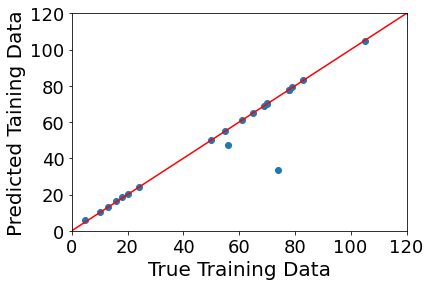

In [11]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
#
plt.scatter(train_labels,train_labels_predict)
plt.ylabel('Predicted Taining Data',fontsize=20)
plt.xlabel('True Training Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

## Due to the overfitting the training data fits  best with almost zero loss 

1/1 [==============================] - 0s 55ms/step


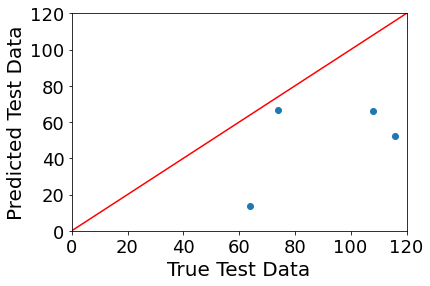

In [12]:
# Check the predictions of only test data by the model
test_labels_predict=model.predict(test_values)
#np.shape(test_labels_predict)
#np.shape(test_labels)
# Plot the predictions of only test data by the model
plt.scatter(test_labels,test_labels_predict)
plt.ylabel('Predicted Test Data',fontsize=20)
plt.xlabel('True Test Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

## The Model fails to capture the test data which is the alien data for the model and hence validation loss is huge

#### Gradient Descent Optimiser

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                272       
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


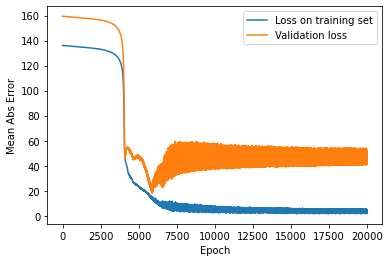

In [13]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
#model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(16, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

#model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(16, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))

# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS

# optimizer = optimizers.RMSprop(0.001) # RMSProp
# optimizer = optimizers.Adam(0.001) # AdaM
optimizer = optimizers.SGD(learning_rate=my_learning_rate,decay=my_decay_rate) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number
        
# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

 Gradient descent optimizes the training process by iteratively adjusting the model parameters to minimize the training loss. As the number of epochs (i.e., training iterations) increases, the optimization process attempts to further minimize the training loss by finding the optimal set of parameters for the given training data. However, minimizing the training loss alone does not guarantee good performance on unseen data. This is where the validation loss comes into play. The validation loss measures the model's performance on a separate validation set, which consists of data that the model has not been trained on


here again at certain nummber of epochs the validation loss gets minimised but after the epochs increased the validation loss shoots up  and the validation loss kept on increasing because of the overfitting

### Predictions by GD

2/2 [==============================] - 0s 6ms/step


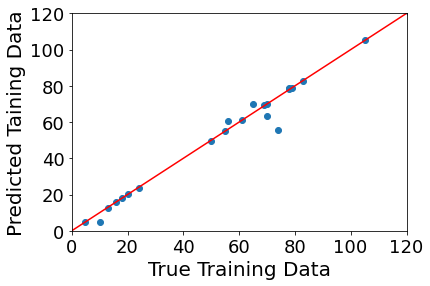

In [19]:
# Check the predictions of training data by the model
train_labels_predict=model.predict(train_values)
#
plt.scatter(train_labels,train_labels_predict)
plt.ylabel('Predicted Taining Data',fontsize=20)
plt.xlabel('True Training Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

## Due to the overfitting the training data fits best with loss minimised

1/1 [==============================] - 0s 56ms/step


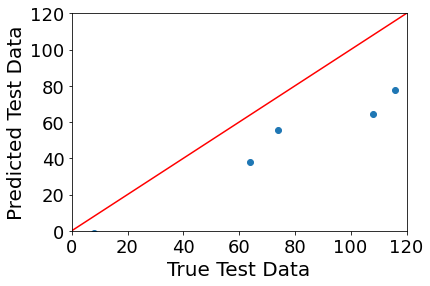

In [20]:
# Check the predictions of only test data by the model
test_labels_predict=model.predict(test_values)
#np.shape(test_labels_predict)
#np.shape(test_labels)
# Plot the predictions of only test data by the model
plt.scatter(test_labels,test_labels_predict)
plt.ylabel('Predicted Test Data',fontsize=20)
plt.xlabel('True Test Data',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,120)
plt.ylim(0,120)
plt.axline([0, 0], [1, 1],color='red')
plt.show()

## The Model fails to capture the test data which is the alien data for the model and hence validation loss is huge

## Q2  . For epochs 20000 and other default setup, run the model for Adam Optimizer for learning rate 0.01, 0.001 and 0.0001 and compare the accuracy vs. epochs. Write your observation and reasoning.


## For 0.01

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 32)                544       
                                                                 
 dense_18 (Dense)            (None, 128)               4224      
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


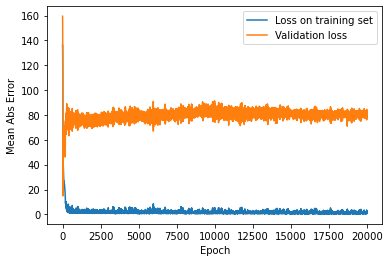

In [14]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

#### for learning rate = 0.0001

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 32)                544       
                                                                 
 dense_22 (Dense)            (None, 128)               4224      
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


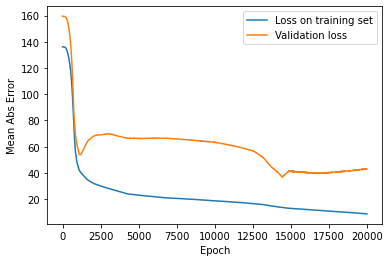

In [15]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.0001
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

## for 0.001

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 16)                272       
                                                                 
 dense_33 (Dense)            (None, 32)                544       
                                                                 
 dense_34 (Dense)            (None, 128)               4224      
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


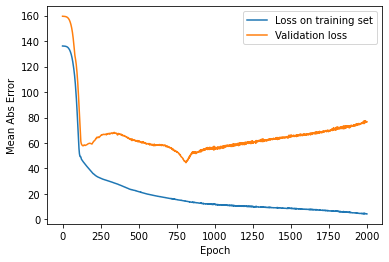

In [24]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.001
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

####  For Learning rate = 0.01 --- Training Loss: 1.758114 Validation Loss: 74.715210
 Here the bias variance trade off is not maintained training loss is  very less but  the validation loss is very high. Overfitting case 
 
#### For  Learning rate = 0.001 ---- Training Loss: 32.577240 Validation Loss: 49.114491
 Here the bias variance trade off is  maintained and training loss and valiation loss are comparable with each other..
 Also with epochs increasing the validaton loss kept on decreasing indicating the model performed better here and learning the data pattern
 
 
#### For Learning rate = 0.0001 ---- Training Loss: 4.340346 Validation Loss: 76.706619  
Here , the bias variance trade off is not maintained training loss is  very less but  the validation loss is very high.This implies model is overfitting

## Q 3 For learning rate 0.01, epochs 2000 and other default setup, run the model for Adam Optimizer for 16 units, 32 units and 64 units in the first layer and compare the loss vs. epochs. Write your observation and reasoning.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 16)                272       
                                                                 
 dense_25 (Dense)            (None, 32)                544       
                                                                 
 dense_26 (Dense)            (None, 128)               4224      
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


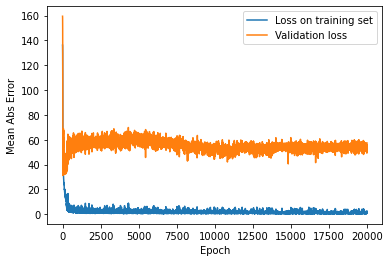

In [16]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000  # r of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000# Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

###  for 32 units in the first layer 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                544       
                                                                 
 dense_29 (Dense)            (None, 32)                1056      
                                                                 
 dense_30 (Dense)            (None, 128)               4224      
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


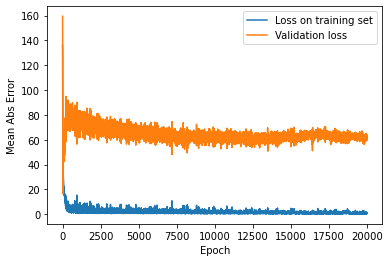

In [17]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense( 32,activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS =20000# Number of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

### For 64 units in the first layer 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 64)                1088      
                                                                 
 dense_33 (Dense)            (None, 32)                2080      
                                                                 
 dense_34 (Dense)            (None, 128)               4224      
                                                                 
 dense_35 (Dense)            (None, 1)                 129       
                                                                 
Total params: 7,521
Trainable params: 7,521
Non-trainable params: 0
_________________________________________________________________


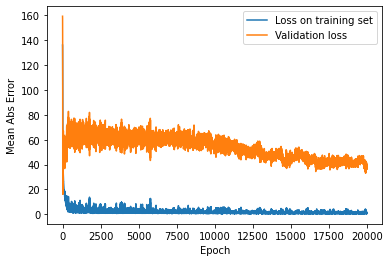

In [18]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

#### for units 16 = --- Training Loss: 2.537484 Validation Loss: 57.663315  



#### For 32 units =  - -- Training Loss: 0.664293 Validation Loss: 60.765953       


#### For 64 Units = - ---- Training Loss: 0.509566 Validation Loss: 39.504852


There is no effect on increasing the units in the first layer ,increasing the number of units in the first layer could increase the risk of overfitting, where the model becomes too complex and starts to memorize the training data instead of learning generalizable patterns. This  lead to poor performance on new, unseen data.

## Q4 For learning rate 0.01, epochs 20000 and other default setup, run the model for Adam Optimizer for ReLU, tanh and softmax activation functions in the hidden layer and compare the accuracy vs. epochs. Write your observation and reasoning?
using only 1000 epochs due to inability of juoyter to perform at faster rate 


#### FOr ReLU activation function 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 16)                272       
                                                                 
 dense_37 (Dense)            (None, 32)                544       
                                                                 
 dense_38 (Dense)            (None, 128)               4224      
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


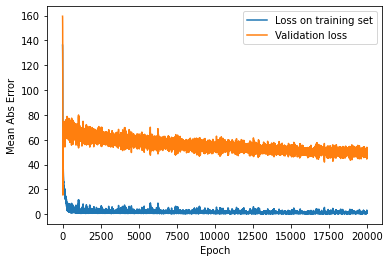

In [19]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                272       
                                                                 
 dense_41 (Dense)            (None, 32)                544       
                                                                 
 dense_42 (Dense)            (None, 128)               4224      
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


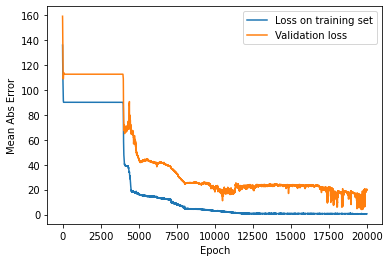

In [20]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='tanh', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='tanh', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 16)                272       
                                                                 
 dense_45 (Dense)            (None, 32)                544       
                                                                 
 dense_46 (Dense)            (None, 128)               4224      
                                                                 
 dense_47 (Dense)            (None, 1)                 129       
                                                                 
Total params: 5,169
Trainable params: 5,169
Non-trainable params: 0
_________________________________________________________________


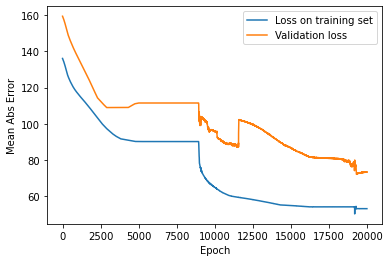

In [21]:
# DEFINITION OF THE MODEL
# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0)
bias_init = initializers.Zeros()

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(train_values.shape[1], ), kernel_initializer=kernel_init, 
                bias_initializer=bias_init))
model.add(Dense(32, activation='softmax', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(128, activation='softmax', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init))

# DEFINITION OF THE OPTIMIZER
EPOCHS = 20000 # Number of EPOCHS
my_learning_rate = 0.01
my_decay_rate = my_learning_rate / EPOCHS


# optimizer = optimizers.RMSprop(0.001) # RMSProp
optimizer = optimizers.Adam(learning_rate=my_learning_rate,decay=my_decay_rate)#0.001) # AdaM
# optimizer = optimizers.SGD(0.001) # SGD

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
model.summary()

#TRAINING
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') 
                         + " Validation Loss: " + "%4f" %logs.get('val_loss')
                         + '                                       \r') # Updates current Epoch Number

EPOCHS = 20000 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known Young's Moduli) 
history = model.fit(train_values, train_labels, batch_size=train_values.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()])


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['loss']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_loss']),label = 'Validation loss')
plt.legend()
plt.show()

#### For ReLU function - - ----  Training Loss: 2.388709 Validation Loss: 46.047752
wRectified Linear Unit (ReLU) does so by outputting x for all x >= 0 and 0 for all x < 0. In other words, it equals max(x, 0). This simplicity makes it more difficult than the Sigmoid activation function and the Tangens hyperbolicus (Tanh) activation function, which use more difficult formulas and are computationally more expensive. In addition, ReLU is not sensitive to vanishing gradients, whereas the other two are, slowing down learning in the network. For ReLU , the validationn loss became lesser than training loss once. 


#### For tanh function  ------ Training Loss: 0.561918 Validation Loss: 19.856144 



#### For Softmax function ----- Training Loss: 53.099979 Validation Loss: 73.350121  

Softmax and Tanh essentially produce non-sparse models because their neurons pretty much always produce an output value: when the ranges are (0, 1)and (-1, 1), respectively, the output either cannot be zero or is zero with very low probabilit
Both have a vanishing Gradient Problem which is also seen in the Validation and training losses in each of the cases.
for Tanh the model is performing better than the other two maintaining the good bias- variance trade off.




In [ ]:
--------------------------------------------------------END-------------------------------------------------------------